In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
dataset = pd.read_csv('loan_approval_dataset.csv')

In [5]:
dataset.columns = dataset.columns.str.strip()

In [6]:
dataset = dataset.applymap(lambda x: x.strip() if isinstance(x, str) else x)

<ipython-input-6-5bd9a2fed6d7>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataset = dataset.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [7]:
dataset['loan_status'] = dataset['loan_status'].replace('Approved', 1)
dataset['loan_status'] = dataset['loan_status'].replace('Rejected', 0)

<ipython-input-7-8f00377f6da0>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['loan_status'] = dataset['loan_status'].replace('Rejected', 0)


In [8]:
dataset['education'] = dataset['education'].replace('Graduate', 1)
dataset['education'] = dataset['education'].replace('Not Graduate', 0)

<ipython-input-8-bdce0316578d>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['education'] = dataset['education'].replace('Not Graduate', 0)


In [9]:
dataset['self_employed'] = dataset['self_employed'].replace('Yes', 1)
dataset['self_employed'] = dataset['self_employed'].replace('No', 0)

<ipython-input-9-527a20c237f6>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['self_employed'] = dataset['self_employed'].replace('No', 0)


In [10]:
dataset.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1
1,2,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0
2,3,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0
3,4,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0
4,5,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0


In [11]:
x = dataset.iloc[:, 1:-1]
y = dataset.iloc[: , -1]

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=13)

In [13]:
normalize_columns = ['income_annum', 'loan_amount', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']

for column in normalize_columns:
    mean = x_train[column].mean()
    std = x_train[column].std()
    x_train[column] = (x_train[column] - mean) / std
    x_test[column] = (x_test[column] - mean) / std

In [14]:
class Model(nn.Module):
  def __init__(self, in_features, h1, h2, out_features):
    super().__init__()
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.out = nn.Linear(h2, out_features)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return x

In [15]:
x_train = torch.FloatTensor(x_train.values)
x_test = torch.FloatTensor(x_test.values)
y_train = torch.LongTensor(y_train.values)
y_test = torch.LongTensor(y_test.values)

In [16]:
len(x_train[0])

11

In [17]:
model = Model(11, 32, 64, 2)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [20]:
epochs = 100
losses = []

for i in range(epochs):
  y_pred = model.forward(x_train)
  loss = criterion(y_pred, y_train)
  losses.append(loss.detach().numpy())

  if i%10 == 0:
    print(f'Epoch: {i} Loss: {loss}')

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch: 0 Loss: 0.7287878394126892
Epoch: 10 Loss: 0.4972476065158844
Epoch: 20 Loss: 0.23771855235099792
Epoch: 30 Loss: 0.1844472736120224
Epoch: 40 Loss: 0.16409878432750702
Epoch: 50 Loss: 0.14545395970344543
Epoch: 60 Loss: 0.13237585127353668
Epoch: 70 Loss: 0.12024157494306564
Epoch: 80 Loss: 0.10877055674791336
Epoch: 90 Loss: 0.0996740385890007


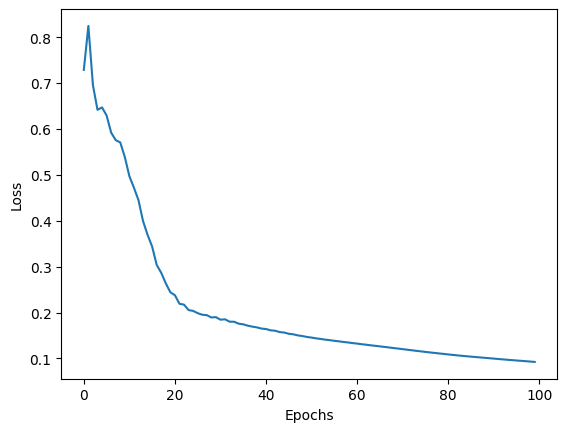

In [23]:
import matplotlib.pyplot as plt
plt.plot(range(epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [26]:
with torch.no_grad():
  correct = 0
  total = 0

  y_pred = model.forward(x_test)

  for i in range(len(y_pred)):
    if y_pred[i].argmax() == y_test[i]:
      correct += 1
    total += 1

  print('Total datapoints in test data: ', total)
  print('Correctly predicted datapoints in test data: ', correct)
  print('Accuracy of the model: ', (correct/total)*100, '%')

Total datapoints in test data:  427
Correctly predicted datapoints in test data:  408
Accuracy of the model:  95.5503512880562 %
